# Feature Overview
To demonstrate the features of mlwhatif, we will use the running example from the paper. It uses a pipeline from the healthcare domain that predicts which patients are at a higher risk of serious complications. The pipeline is implemented using native constructs from the popular pandas and scikit-learn libraries.

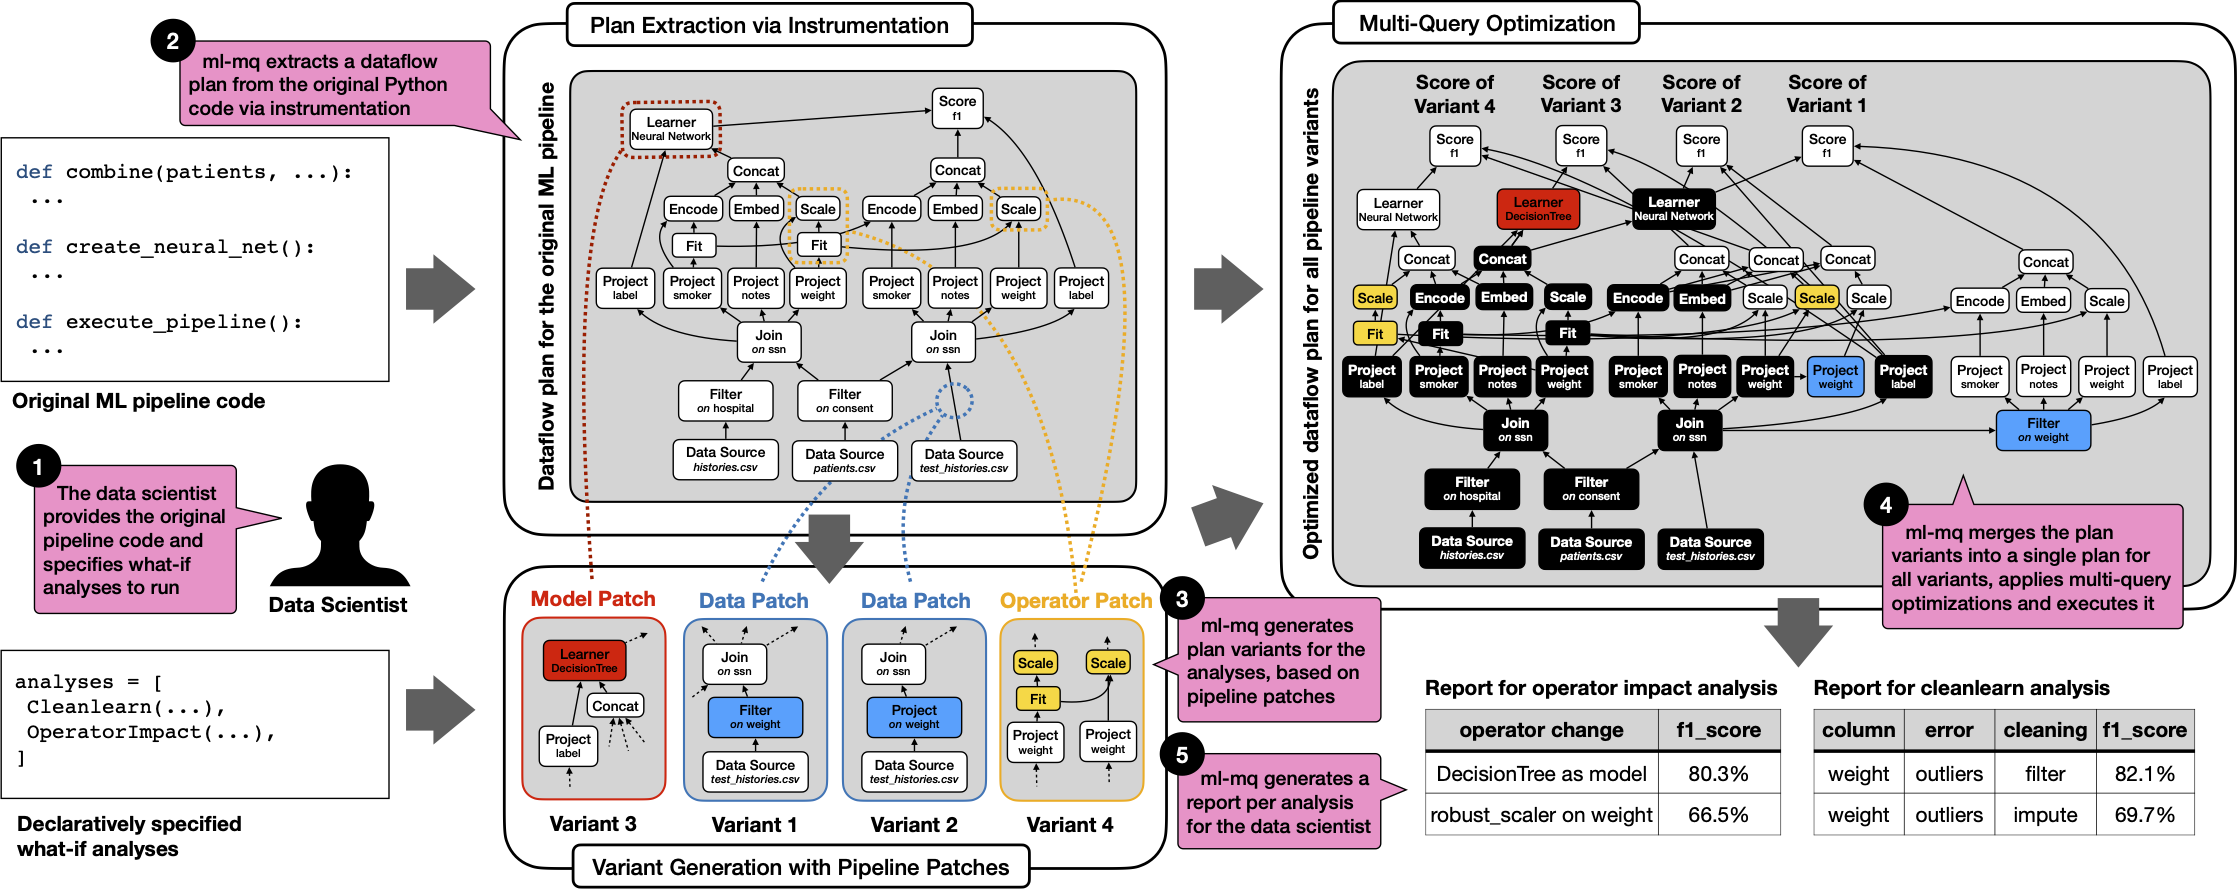

In [1]:
from demo.feature_overview.demo_utils import display_paper_figure, display_demo_source_code
display_paper_figure()

Let us start by looking at the full pipeline source code.

In [2]:
import os
from mlwhatif.utils import get_project_root

DEMO_PY = os.path.join(str(get_project_root()), "demo", "feature_overview", "healthcare.py")
display_demo_source_code(DEMO_PY)

In this scenario, we realized that there are problems with respect to the `weight` attribute in the test data of the pipeline. Sometimes the weight is zero, in other cases the weight is unnaturally high. We now want to investigate how such errors might impact our pipeline.

To conduct our what-if analyses, we do not need to rewrite this pipeline file, we can use it directly as input for mlwhatif.

We use two what-if analyses. The first one is `CleanLearn`. We want to try two different cleaning approaches for outliers on our test data, dropping and imputing outliers. In addition, we will use the what-if analysis `OperatorImpact` to understand the impact of certain operators in our pipeline, the standard scaling for `weight`, and the model.

The central entry point of mlwhatif is the `PipelineAnalyzer`. To use mlwhatif, we use it and pass it the path to the runnable version of the example pipeline. Here, we have the example pipeline in a healthcare.py file, but e.g., `.ipynb` jupyter notebook files are supported, too. Then, we define the set of what-if analyses we want mlwhatif to run. Then, we execute the pipeline. Mlwhatif returns a `AnalysisResults` object, which contains the output of our what-if analyses. This API is very close to the mlinspect API, because the implementation uses mlinspect as a basis for its plan extraction.

In [3]:
from mlwhatif import PipelineAnalyzer
from sklearn.linear_model import LogisticRegression
from example_pipelines.healthcare import custom_monkeypatching
from demo.feature_overview.clean_learn import Clean, ErrorType, CleanLearn
from demo.feature_overview.operator_impact import OperatorImpact
from functools import partial
import warnings
warnings.filterwarnings('ignore')  # To keep the output readable


cleanlearn = CleanLearn(column="weight",
                        error=ErrorType.OUTLIER,
                        cleanings=[Clean.FILTER, Clean.IMPUTE],
                        outlier_func=lambda y: (y > 120) | (y < 30),
                        impute_constant=70)

op_impact = OperatorImpact(robust_scaling=True,
                           named_model_variants=[('logistic_regression', partial(LogisticRegression))])

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(cleanlearn) \
    .add_what_if_analysis(op_impact) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .execute()

cleanlearn_report = analysis_result.analysis_to_result_reports[cleanlearn]
op_impact_report = analysis_result.analysis_to_result_reports[op_impact]

2022-10-14 18:08:32 INFO  Running instrumented original pipeline...
2022-10-14 18:08:32 INFO  Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
2022-10-14 18:08:32 INFO  ---RUNTIME: Importing and monkey-patching took 146.91686630249023 ms
2022-10-14 18:08:33 INFO  ---RUNTIME: Original pipeline execution took 1320.1141357421875 ms (excluding imports and monkey-patching)
2022-10-14 18:08:33 INFO  Starting execution of 2 what-if analyses...
2022-10-14 18:08:33 INFO  Start plan generation for analysis CleanLearn...
2022-10-14 18:08:33 INFO  ---RUNTIME: Plan generation took 0.11110305786132812 ms
2022-10-14 18:08:33 INFO  Start plan generation for analysis OperatorImpact...
2022-10-14 18:08:33 INFO  ---RUNTIME: Plan generation took 0.18310546875 ms
2022-10-14 18:08:33 INFO  Estimated runtime of original DAG is 1286.8306636810303ms
2022-10-14 18:08:33 INFO  Performing Multi-Query Optimization
2022-10-14 18:08:33 INFO  Estimated unoptimized wh

Let us start by looking at the report generated by the `cleanlab` analysis. Each row in this pandas `DataFrame` corresponds to one pipeline variant executed by mlwhatif. In the first report column, we see a column from the original pipeline that was cleaned in this pipeline variant. In the second column, we see the type of error in the column. In the third column, we see the cleaning method tried in the variant. In the fourth column, we see the utility score of the variant.

In the first row, we see the output for the original pipeline.

Here, we find that both cleaning approaches improve the performance of our pipeline. Here, the outlier imputation strategy results in slightly higher scores then just dropping outliers.

In [4]:
cleanlearn_report

,corrupted_column,error,cleaning_method,accuracy_score_L67
0,None,None,None,0.754220
1,weight,outliers,filter,0.804712
2,weight,outliers,impute,0.810997


Next, we try looking at the report generated by the `op_impact` analysis. In the first column, we see the type of the operator we measured the impact of. In column 2 and 3, we see the line number and source code of the operator. In the fourth column, we see the replacement strategy we tried. In the final column, we see the resulting score output again.

Again, the first row contains the output of the original pipeline.

Here, we find that both alternative variants do not help dealing with the `weight` attribute issues we encountered in our test data.

In [5]:
op_impact_report


,operator_type,operator_lineno,operator_code,strategy_description,accuracy_score_L67
0,None,NaN,None,None,0.754220
1,Transformer,46.0,StandardScaler(),robust scale instead,0.686957
2,Estimator,64.0,"MyKerasClassifier(create_neural_net, epochs=5,...",logistic_regression instead,0.686957


## A small peak under the hood
Internally, mlwhatif extracts a re-executable plan of the original pipeline and uses multi-query optimization to optimize the execution of what-if analyses. Let us take a look at what this looks like for our example.

In [6]:
from IPython.core.display import Image
from demo.feature_overview.demo_utils import save_plans_to_disk
original_plan, optimized_plan = save_plans_to_disk(analysis_result)

Here we see the original plan mlwhatif extracted from the source code. Contrary to the paper, in the implementation, the plans go from top to bottom, so they can be read easier when displayed next to the corresponding source code. The data source operators are at the top of the plan, the final score aggregation is at the bottom. The plan consists of operators like projections, selections, joins, transformers, and the classifier.

Note that we can also see the output shape and runtime of each operator.

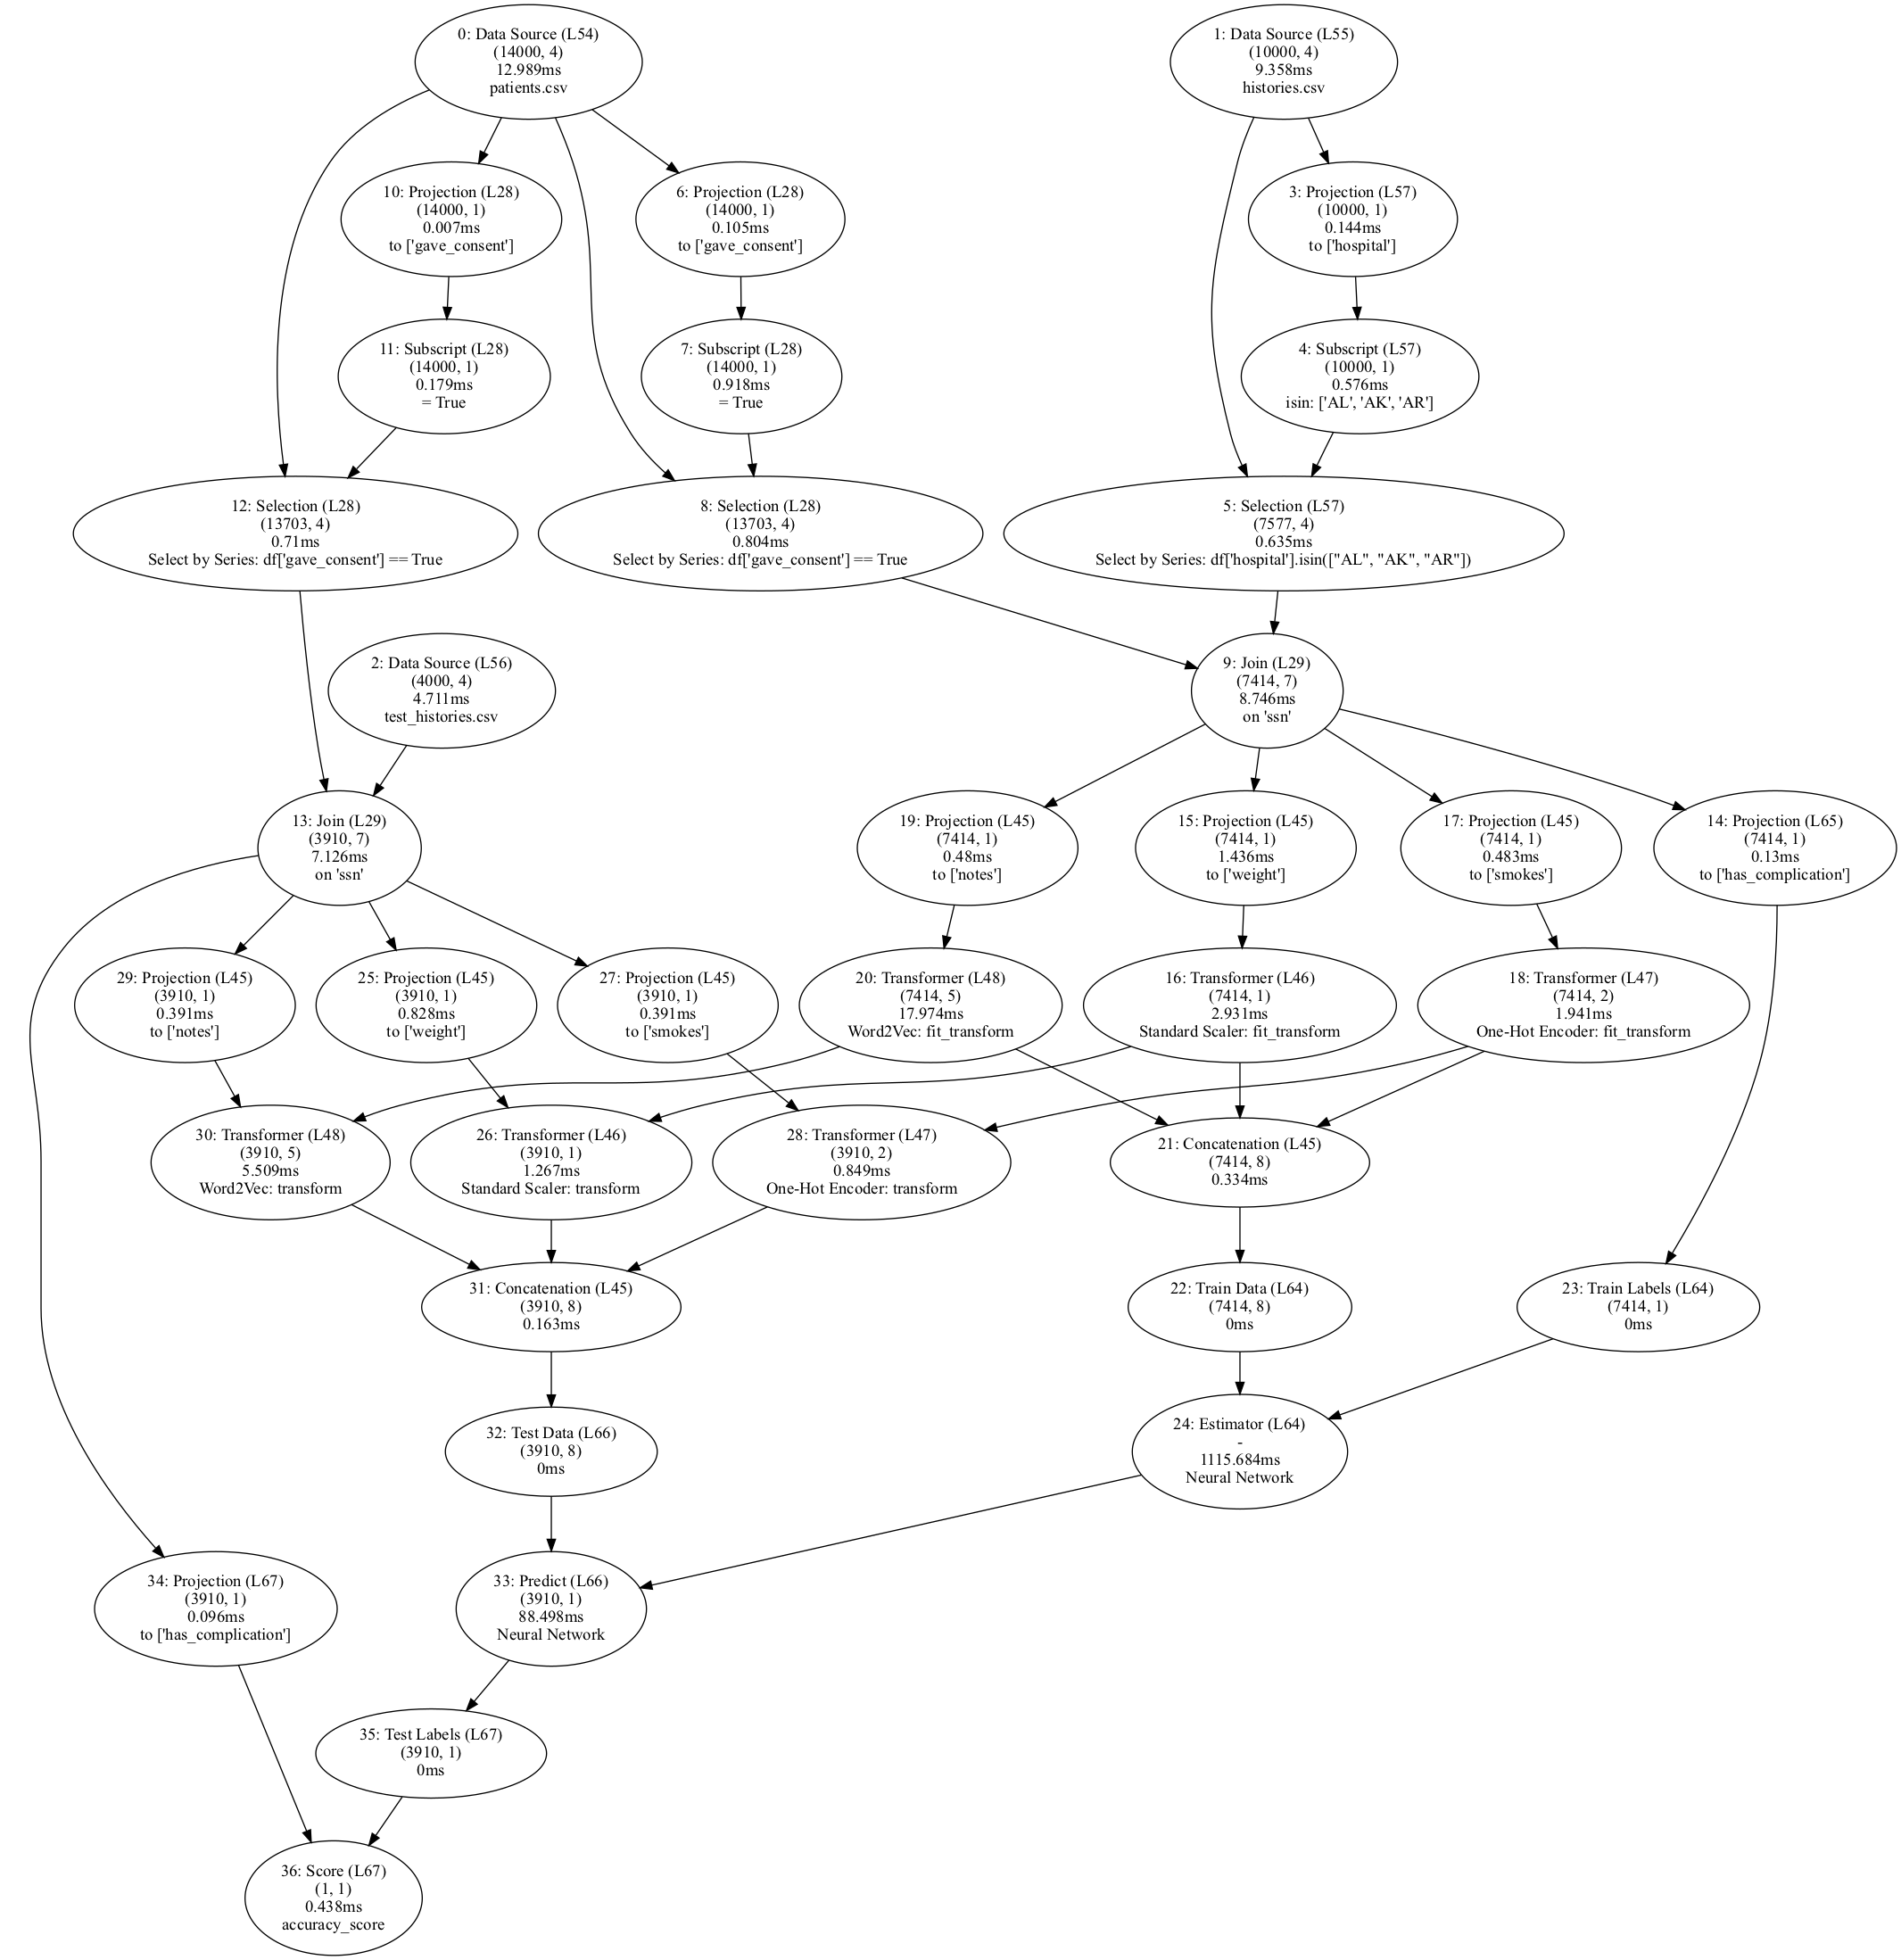

In [7]:
Image(filename=original_plan)

Next, we look at the optimised plan mlwhatif generated. The plan combines the computation for all the variants. Thanks to our multi-query optimisation, it is still somewhat comparable in size to the original plan.
When looking closely at the plan, we can find the four patches introduced by the two what-if analyses. In the following, we list the operator identifier numbers for the operators created by our patches.
* Pipeline Variant 1: An outlier filter was added for this variant. -> Operator 38.
* Pipeline Variant 2: An outlier replacement operator was added for this variant. -> Operator 40
* Pipeline Variant 3: Standard Scaling was replaced with Robust scaling for this variant. -> Operator 42
* Pipeline Variant 4: The Neural Network was replaced with Logistic Regression for this variant. -> Operator 44

For each of the variants, we can see one separate score operation at the bottom of the plan, with the operator identifiers 56, 63, 73, and 77.

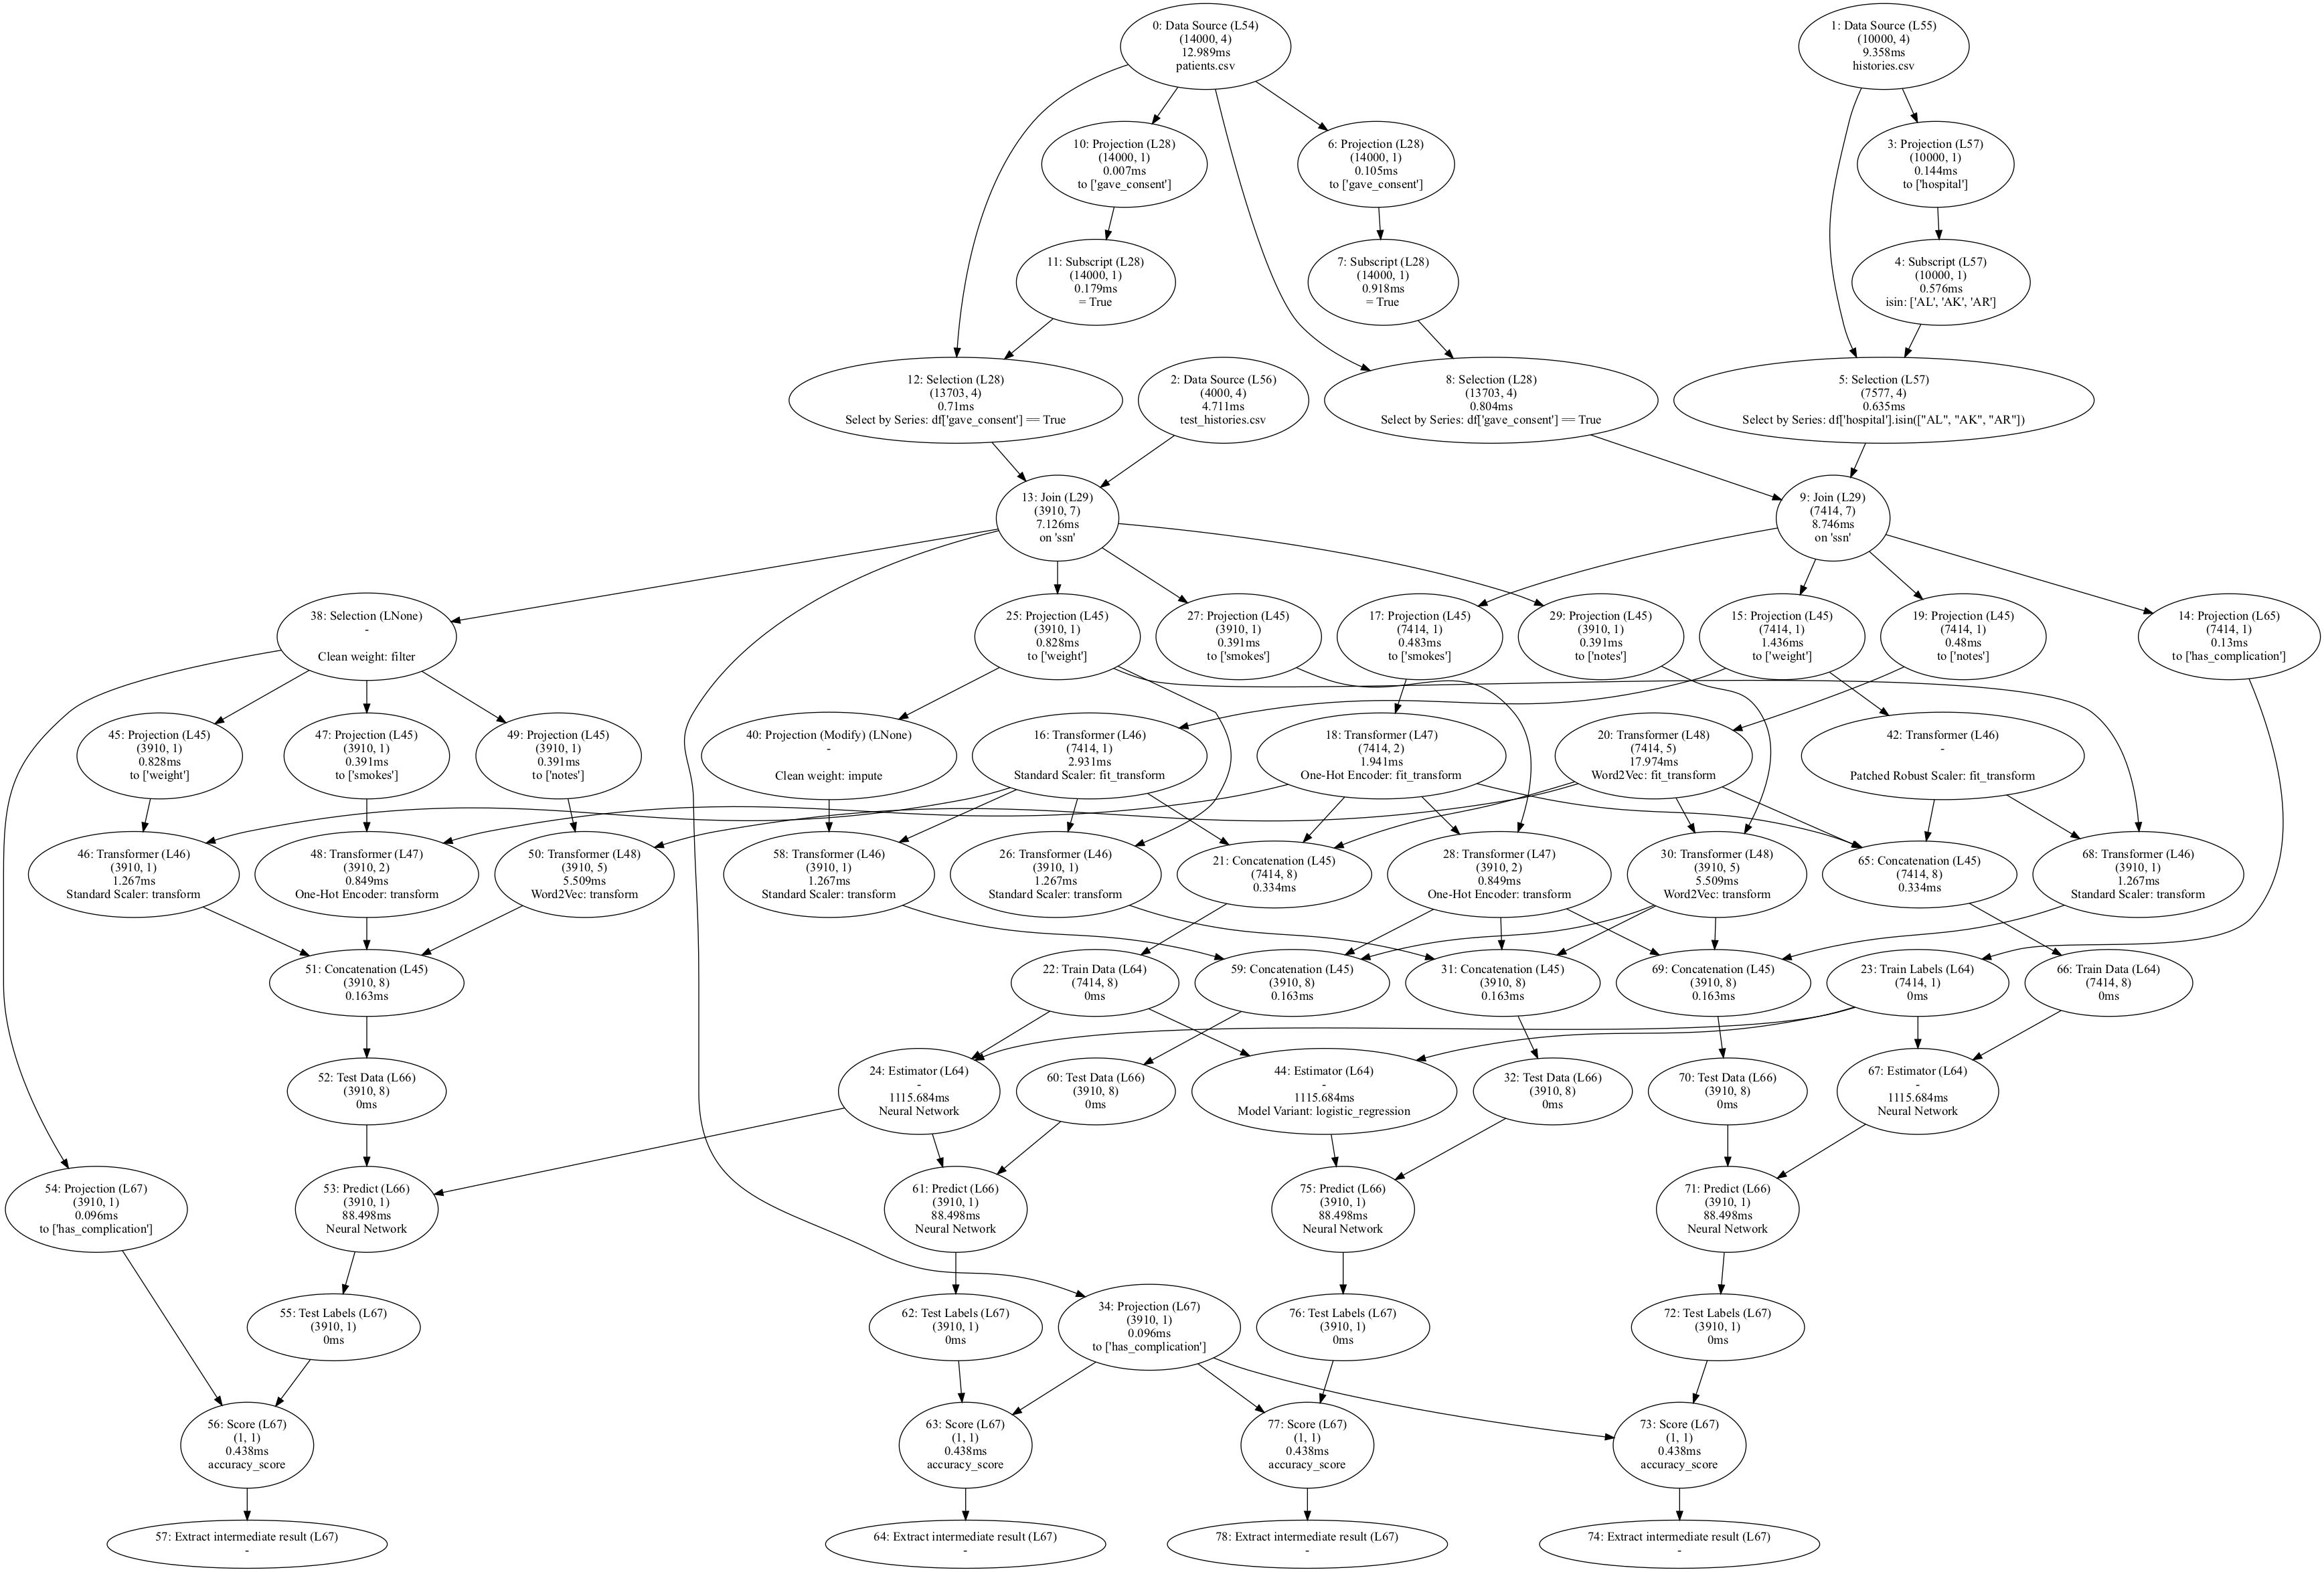

In [8]:
Image(filename=optimized_plan)

## Further reading

In this demo notebook, we used relatively simple what-if analyses for demonstration purposes and replicated the simple example from the paper. We also prepared another demonstration notebook for advanced users already fully familiar with the ideas behind our approach. To get a full overview over our real, more powerful what-if analyses (as proposed by different papers) and a full overview over the functionality of mlwhatif, we refer to [this second notebook](../advanced_features/advanced_features.ipynb).